# Ensemble Learning

## Weighted Mean Ensemble

In [1]:
from models.ensemble_weighted_mean import EnsembleWeightedMean

ensemble_direct_optimization = EnsembleWeightedMean(optimization=True)
ensemble_direct_optimization_with_features = EnsembleWeightedMean(optimization=True, with_features=True)
ensemble_weigthed_mean = EnsembleWeightedMean(optimization=False)

data = 'ensemble-pd-hek293t-pe2.csv'

ensemble_direct_optimization.fit(data)
direct_optimization_performance = ensemble_direct_optimization.test(data) 

ensemble_weigthed_mean.fit(data)
weighted_mean_performance = ensemble_weigthed_mean.test(data)

ensemble_direct_optimization_with_features.fit(data)
with_features_performance = ensemble_direct_optimization_with_features.test(data)

Training Ensemble
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      755.8152      272.8594     +  0.4104
      2      431.9329      726.2324        0.1567
      3      176.2978      265.1272     +  0.1487
      4      194.2205      284.7998        0.1614
      5      152.5140      280.3324        0.3168
      6      144.8839      253.4539     +  0.1654
      7      131.6154      236.0810     +  0.1769
      8      132.8533      235.0223     +  0.3330
      9      130.1241      232.5447     +  0.1945
     10      126.1316      223.5701     +  0.1834
     11      126.2828      222.2504     +  0.2965
     12      124.4471      218.3700     +  0.1774
     13      122.9154      214.1604     +  0.1739
     14      122.3356      211.9355     +  0.3433
     15      120.9296      208.4738     +  0.1653
     16      120.1357      205.8650     +  0.3222
     17      119.2724      203.3585     +  0.1754
     18      118.4011      200.8

/home/lupeiheng/development/ox-dissertation/models/ensemble_weighted_mean.py:191: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  predictions = torch.tensor(predictions, dtype=torch.float32).T


Training Ensemble
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1      879.8412      555.8761     +  0.3245
      2      449.4034      320.8473     +  0.1942
      3      262.3935      292.1826     +  0.1814
      4      274.7401      387.6151        0.3117
      5      207.2222      260.1427     +  0.1773
      6      202.6838      314.7000        0.1723
      7      157.5243      243.7459     +  0.1609
      8      158.3821      258.7623        0.3180
      9      143.1275      232.7533     +  0.1636
     10      147.1028      236.0027        0.1732
     11      140.7117      222.9752     +  0.3175
     12      147.3488      222.7809     +  0.1682
     13      147.4596      215.6115     +  0.1753
     14      158.6883      212.7016     +  0.3690
     15      169.1886      210.0781     +  0.2525
     16      191.8309      205.5863     +  0.2442
     17      220.5169      204.8927     +  0.3769
     18      265.9939      201.9

Pearson


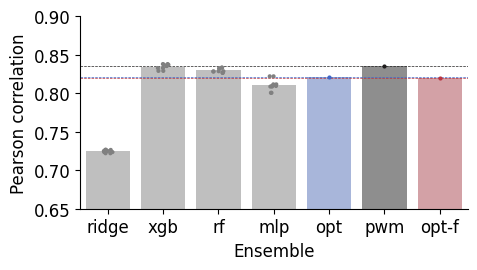

opt vs ridge t-statistic: 50.82733736132962, p-value: 2.2172555711456757e-12
Significant
opt vs xgb t-statistic: -3.922678146045233, p-value: 0.0034967119545746004
Significant
opt vs rf t-statistic: -3.26552559611355, p-value: 0.009752207929558814
Significant
opt vs mlp t-statistic: 1.3230917341419022, p-value: 0.21843202337621198
Not significant
pwm vs ridge t-statistic: 58.700523723548926, p-value: 6.087774182245172e-13
Significant
pwm vs xgb t-statistic: 0.26187926127032024, p-value: 0.799309583419286
Not significant
pwm vs rf t-statistic: 1.9685221504522117, p-value: 0.08053332942055727
Not significant
pwm vs mlp t-statistic: 3.2730488675391607, p-value: 0.009635664290168334
Significant
opt-f vs ridge t-statistic: 50.7316217025701, p-value: 2.2550697741284443e-12
Significant
opt-f vs xgb t-statistic: -3.9735505184788664, p-value: 0.0032372104483092056
Significant
opt-f vs rf t-statistic: -3.3291568001766643, p-value: 0.008810902413176176
Significant
opt-f vs mlp t-statistic: 1.2993

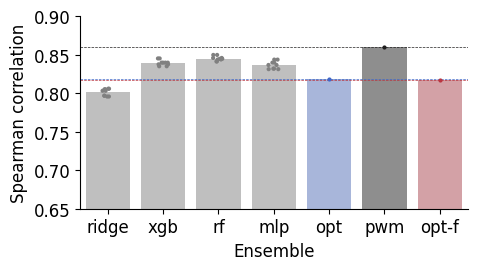

opt vs ridge t-statistic: 3.583402055847949, p-value: 0.0058992945357857155
Significant
opt vs xgb t-statistic: -5.731641768442385, p-value: 0.000282766932633331
Significant
opt vs rf t-statistic: -8.77321215108877, p-value: 1.051524929899319e-05
Significant
opt vs mlp t-statistic: -3.566829839846166, p-value: 0.006054202365791058
Significant
pwm vs ridge t-statistic: 12.548634642392162, p-value: 5.256732062787184e-07
Significant
pwm vs xgb t-statistic: 5.595443756422363, p-value: 0.00033622857436508316
Significant
pwm vs rf t-statistic: 4.932423983895909, p-value: 0.0008106344143909329
Significant
pwm vs mlp t-statistic: 4.543257096418127, p-value: 0.0013993741658809037
Significant
opt-f vs ridge t-statistic: 3.423194259887194, p-value: 0.007589485215883859
Significant
opt-f vs xgb t-statistic: -5.934055636580195, p-value: 0.00021961933727912203
Significant
opt-f vs rf t-statistic: -9.01813047710315, p-value: 8.398613239080003e-06
Significant
opt-f vs mlp t-statistic: -3.7117562698708

In [2]:
import numpy as np
import pandas as pd
from os.path import join as pjoin

direct_op_pearson, direct_op_spearman = direct_optimization_performance
performance_weighted_pearson, performance_weighted_spearman = weighted_mean_performance
performance_with_features_pearson, performance_with_features_spearman = with_features_performance

# join the performance values, ignore the common keys
direct_op_pearson.update(performance_weighted_pearson)
direct_op_spearman.update(performance_weighted_spearman)

direct_op_pearson.update(performance_with_features_pearson)
direct_op_spearman.update(performance_with_features_spearman)

performance_pearson = direct_op_pearson
performance_spearman = direct_op_spearman

# plot the performance as bar plot
import matplotlib.pyplot as plt
import seaborn as sns

alpha = 0.5
f_size = 12
# plot the bar plot on top of the strip plot
# bar plot should be shortened to emphasize the difference in values
for name, performance in zip(['Pearson', 'Spearman'], [performance_pearson, performance_spearman]):
    # performance = pd.DataFrame({'Models': list(performance.keys()), 'Performance': list(performance.values()), 'Category': [0 if 'op' in model or 'pwm' in model else 1 for model in performance.keys()]})
    # print(performance)
    # add a category column
    print(name)
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.set_ylim(0.65, 0.9)
    colour_palette = iter(sns.color_palette('icefire', n_colors=3))
    colours = ['gray' if not ('opt' in model or 'pwm' in model) else next(colour_palette) for model in performance.keys()]
    sns.stripplot(data=performance, ax=ax, alpha=1, jitter=0.1, size=3, palette=colours)
    sns.barplot(data=performance, ax=ax, alpha=alpha, palette=colours, errorbar=None)
    ax.set_xlabel('Ensemble', fontsize=f_size)
    ax.set_ylabel(f'{name} correlation', fontsize=f_size)
    ax.tick_params(axis='both', which='major', labelsize=f_size)
    ax.tick_params(axis='both', which='minor', labelsize=f_size)
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # show a horizontal line at the mean for 'opt', 'pwm' models of matching color
    for ind, model in enumerate(performance.keys()):
        if 'opt' in model or 'pwm' in model:
            ax.axhline(y=performance[model], color=colours[ind], linestyle='--', linewidth=0.5)
    # rotate the x tick labels
    plt.show()
    
    # perform paired t-test between opt pwm models and the rest
    from scipy.stats import ttest_ind
    opt_pwm_values = {model: performance[model] for model in performance.keys() if 'opt' in model or 'pwm' in model}
    rest_values = {model: performance[model] for model in performance.keys() if not ('opt' in model or 'pwm' in model)}

    for opt_pwm, performance_opt_pwm in zip(opt_pwm_values.keys(), opt_pwm_values.values()):
        for rest, performance_rest in zip(rest_values.keys(), rest_values.values()):
            t_stat, p_value = ttest_ind(performance_opt_pwm, performance_rest)
            print(f'{opt_pwm} vs {rest} t-statistic: {t_stat}, p-value: {p_value}')
            if p_value < 0.05:
                print('Significant')
            else:
                print('Not significant')
                
    # save the figure
    fig.savefig(pjoin('dissertation', 'figures', f'ensemble_{name.lower()}.pdf'), bbox_inches='tight')